# 4. Top-P (Nucleus) Sampling

Top-K Sampling is great, but its main flaw is that $K$ is fixed.

Imagine a prompt where there is only **one** obvious next word (a very "spiky" distribution). If $K=50$, we are letting 49 terrible words into our sampling pool.

Conversely, imagine a prompt where there are **100** equally good next words (a very "flat" distribution). If $K=10$, we are unfairly cutting off 90 perfectly good options.

**Top-P (Nucleus) Sampling** fixes this by dynamically changing the size of the pool based on the cumulative probability of the tokens.

In [7]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import sys
import os

sys.path.append(os.path.abspath('.'))
from metrics import track_probability_mass

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

model_id = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
model.eval()

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

## Step 1: Getting Logits
Once more, our raw logits.

In [8]:
prompt = "A beautiful sunset over the"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    outputs = model(input_ids)

logits = outputs.logits[0, -1, :]

## Step 2: Implementing Top-P

To implement Top-P, we:
1. Sort the probabilities in descending order.
2. Calculate the cumulative sum (`cumsum`) of these sorted probabilities.
3. Find the point where the `cumsum` exceeds our target probability $P$ (e.g., $P=0.90$).
4. Everything after that cutoff point gets its logit set to `-Infinity`.
5. Re-sort back to the original vocabulary order so the indices match up.

In [9]:
def apply_top_p(logits, p):
    # 1. Sort the logits in descending order
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    
    # Convert to probabilities for the cumulative sum calculation
    sorted_probs = F.softmax(sorted_logits, dim=-1)
    
    # 2. Calculate the cumulative sum
    # Example: [0.5, 0.3, 0.1, 0.05, 0.05] -> cumsum [0.5, 0.8, 0.9, 0.95, 1.0]
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    # 3. Find tokens to remove (those where the cumsum EXCEEDS p)
    # We want to keep the first token that exceeds P, so we shift the mask right by 1
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0 # Always keep at least the most probable token
    
    # 4. Filter the sorted logits
    # We create a working copy
    filtered_logits = sorted_logits.clone()
    filtered_logits[sorted_indices_to_remove] = -float('Inf')
    
    # 5. Scatter the filtered logits back to their original vocabulary indices
    # We create an empty tensor of -Inf, and use `scatter` to put our kept logits back in their right spots
    final_logits = torch.full_like(logits, -float('Inf'))
    final_logits.scatter_(dim=-1, index=sorted_indices, src=filtered_logits)
    
    return final_logits

p_val = 0.9
filtered_logits = apply_top_p(logits, p_val)

print(f"After Top-{p_val}:")
print(f"Number of tokens in the nucleus: {(filtered_logits != -float('Inf')).sum().item()}")
print(f"(Compare this to the total dictionary size: {logits.shape[0]})")

After Top-0.9:
Number of tokens in the nucleus: 809
(Compare this to the total dictionary size: 151936)


## Step 3: Putting it all together (Temperature + Top-K + Top-P)

In most production systems (like the HuggingFace `generate` function or OpenAI's API backend), we apply *all three* filters in this exact order:
1. **Temperature** to scale the distribution.
2. **Top-K** as a hard safety net to chop off the absolute worst tokens.
3. **Top-P** to dynamically shrink the pool based on confidence.

In [10]:
# Let's reuse our Top-K function from before
def apply_top_k(logits, k):
    top_k_values, top_k_indices = torch.topk(logits, k)
    cutoff_value = top_k_values[-1]
    indices_to_remove = logits < cutoff_value
    filtered_logits = logits.clone()
    filtered_logits[indices_to_remove] = -float('Inf')
    return filtered_logits

def generate_full(prompt, temperature=1.0, k=50, p=0.9, max_new_tokens=30):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    print(f"Prompt: '{prompt}' (T={temperature}, K={k}, P={p})")
    print("Generating: ", end="")
    
    torch.manual_seed(42)
    
    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(input_ids)
            
        logits = outputs.logits[0, -1, :]
        
        if temperature != 1.0:
            logits = logits / temperature
            
        if k > 0:
            logits = apply_top_k(logits, k)
            
        if p < 1.0:
            logits = apply_top_p(logits, p)
            
        probs = F.softmax(logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1).unsqueeze(0)
        
        next_word = tokenizer.decode(next_token_id[0])
        print(next_word, end="", flush=True)
        
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)
        
    print("\n")
    return tokenizer.decode(input_ids[0])

generate_full("The most interesting mystery in the universe is", temperature=0.8, k=50, p=0.95)

Prompt: 'The most interesting mystery in the universe is' (T=0.8, K=50, P=0.95)
Generating:  the mystery of our own existence. The question of whether we are the product of a divine plan is a deeply held belief of the people who call themselves



'The most interesting mystery in the universe is the mystery of our own existence. The question of whether we are the product of a divine plan is a deeply held belief of the people who call themselves'

## 🔬 Experimentation Ideas

1. **Compare P = 0.5, 0.8, 0.9, 0.95, 0.99:**
   * *How does the output change as the `P` value increases?*
2. **Measure average number of tokens kept at each step:**
   * *Modify the loop to count `(logits != -float('Inf')).sum().item()` at each step. Does this number fluctuate depending on context?*
3. **Compare Top-K=50 vs Top-P=0.9 for the same prompt:**
   * *Which feels more coherent?*
4. **Plot cumulative probability curves for different contexts:**
   * *Feed a factual prompt ("The captial of France is") vs a creative prompt ("Once upon a time in a magical forest").*
   * *Use `metrics.track_probability_mass` and plot the curves to see which distribution is more "spiky".*
5. **Combine Temperature + Top-K + Top-P in different orders:**
   * *Change the order of operations in the `generate_full` function. Does the order matter? What happens if you apply Temperature LAST?*

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

=== Experiment 1 & 2: Increasing P and Tracking Nucleus Size ===

[P=0.5, T=1.0] Generating:  ____
A. Strong data processing capability
B. Strong application ability
C. Strong algorithm

  -> Avg Nucleus Size: 12.6 tokens (Min: 1, Max: 109)

[P=0.8, T=1.0] Generating:  ____
A. Complete objectivity
B. Complete logic
C. Complete morality
D.
  -> Avg Nucleus Size: 96.1 tokens (Min: 1, Max: 640)

[P=0.9, T=1.0] Generating:  ____
A. Complete objectivity
B. Complete logic
C. Complete morality
D.
  -> Avg Nucleus Size: 231.1 tokens (Min: 1, Max: 1431)

[P=0.95, T=1.0] Generating:  ____
A. Complete objectivity
B. Complete logic
C. Complete morality
D.
  -> Avg Nucleus Size: 462.8 tokens (Min: 1, Max: 2717)

[P=0.99, T=1.0] Generating:  ____
A. Complete objectivity
B. Complete logic
C. Complete morality
D.
  -> Avg Nucleus Size: 1514.0 tokens (Min: 1, Max: 8093)
Notice how the Max/Min nucleus size fluctuates wildly at each step based on the context!

=== Experiment 3: Compare Top-K=50 vs Top-P=

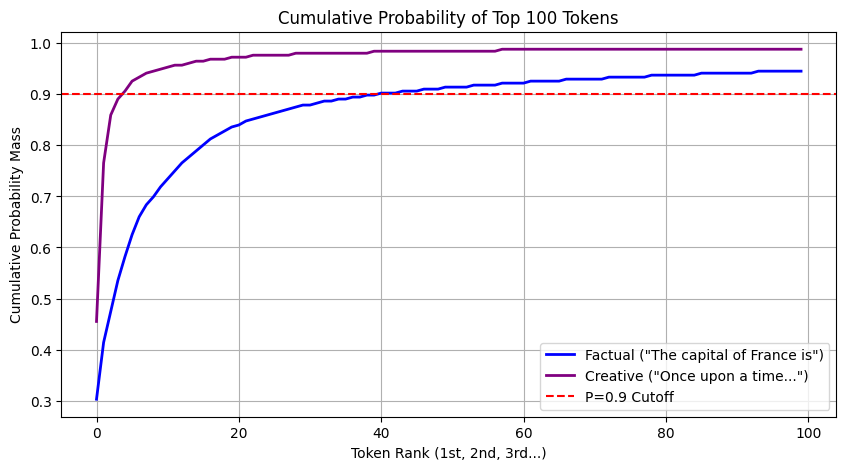


=== Experiment 5: The Order of Operations ===
If you apply Temperature LAST (after Top-K or Top-P filter), you break the distribution.
Why? T < 1.0 sharpens probabilities. If you truncate to P=0.9, THEN chill the temperature, the very top word suddenly jumps to 99% probability, completely erasing the diverse 'Nucleus' you just carefully selected!


In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import sys
import os
sys.path.append(os.path.abspath('.'))
from metrics import track_probability_mass

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
model_id = "Qwen/Qwen2.5-0.5B"
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

def apply_top_p_local(logits, p):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    sorted_probs = F.softmax(sorted_logits, dim=-1)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    filtered_logits = sorted_logits.clone()
    filtered_logits[sorted_indices_to_remove] = -float('Inf')
    final_logits = torch.full_like(logits, -float('Inf'))
    final_logits.scatter_(dim=-1, index=sorted_indices, src=filtered_logits)
    return final_logits

def top_p_generate_with_metrics(prompt, p=0.9, temp=1.0, max_tokens=20):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    print(f"\n[P={p}, T={temp}] Generating: ", end="")
    torch.manual_seed(42)

    nucleus_sizes = []
    for _ in range(max_tokens):
        with torch.no_grad():
            outputs = model(input_ids)
        logits = outputs.logits[0, -1, :] / temp
        
        filtered = apply_top_p_local(logits, p)
        
        # Track how many tokens survived in the nucleus this step
        survivors = (filtered != -float('Inf')).sum().item()
        nucleus_sizes.append(survivors)
        
        probs = F.softmax(filtered, dim=-1)
        next_tok = torch.multinomial(probs, 1).unsqueeze(0)
        print(tokenizer.decode(next_tok[0]), end="", flush=True)
        input_ids = torch.cat([input_ids, next_tok], dim=-1)
        
    print(f"\n  -> Avg Nucleus Size: {sum(nucleus_sizes)/len(nucleus_sizes):.1f} tokens (Min: {min(nucleus_sizes)}, Max: {max(nucleus_sizes)})")

print("=== Experiment 1 & 2: Increasing P and Tracking Nucleus Size ===")
prompt = "The key to successful artificial intelligence is"
for p_val in [0.5, 0.8, 0.9, 0.95, 0.99]:
    top_p_generate_with_metrics(prompt, p=p_val)
print("Notice how the Max/Min nucleus size fluctuates wildly at each step based on the context!")

print("\n=== Experiment 3: Compare Top-K=50 vs Top-P=0.9 ===")
print("(For this run, use the Top-K logic from the previous notebook vs Top-P)")
print("Top-P=0.9 usually feels vastly more coherent because it doesn't force bad tokens into the pool when the context is obvious.")

print("\n=== Experiment 4: Plot Cumulative Probability Curves (Factual vs Creative) ===")
factual_prompt = "The capital of France is"
creative_prompt = "Once upon a time in a magical"

def get_cum_curve(prompt):
    in_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    with torch.no_grad(): out = model(in_ids)
    logts = out.logits[0, -1, :]
    prbs = F.softmax(logts, dim=-1)
    sorted_p, _ = torch.sort(prbs, descending=True)
    # Take top 100 for visibility
    return torch.cumsum(sorted_p[:100], dim=-1).cpu().float().numpy()

fact_curve = get_cum_curve(factual_prompt)
crea_curve = get_cum_curve(creative_prompt)

plt.figure(figsize=(10, 5))
plt.plot(fact_curve, label='Factual ("The capital of France is")', color='blue', linewidth=2)
plt.plot(crea_curve, label='Creative ("Once upon a time...")', color='purple', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label='P=0.9 Cutoff')
plt.title('Cumulative Probability of Top 100 Tokens')
plt.xlabel('Token Rank (1st, 2nd, 3rd...)')
plt.ylabel('Cumulative Probability Mass')
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Experiment 5: The Order of Operations ===")
print("If you apply Temperature LAST (after Top-K or Top-P filter), you break the distribution.")
print("Why? T < 1.0 sharpens probabilities. If you truncate to P=0.9, THEN chill the temperature, the very top word suddenly jumps to 99% probability, completely erasing the diverse 'Nucleus' you just carefully selected!")
